In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, VBox, HBox, interactive_output
from typing import Callable, Dict
from utils import (
    create_slider,
    get_slider_values,
    heteroskedastic_noise,
    generate_noisy_observations,
    generate_sobol_points,
)
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.priors import LogNormalPrior
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from matplotlib import pyplot as plt
from botorch.acquisition import ExpectedImprovement

dtype = torch.double

## Example - Enzyme Cascade

$$
P(E) = 
\sum_{i=1}^N \left( (-1)^{i+1} \cdot P_{\text{max},i} \cdot \frac{\left(\frac{E}{s}\right)^{n_i}}{K_i^{n_i} + \left(\frac{E}{s}\right)^{n_i}} \right) 
- I \cdot \frac{\left(\frac{E}{s}\right)^2}{\left(\frac{E}{s}\right)^2 + K_I^2}
$$

### Tune ground truth to your heart's content

In [ ]:
# Function for plotting
def enzyme_truth(
    x, p_max1, k1, n1, p_max2, k2, n2, p_max3, k3, n3, p_max4, k4, n4, i, k_I, s
):
    """
    True relation of enzyme concentration to productivity.
    Parameters
    ----------
    x : float
        Enzyme concentration.
    Returns
    -------
    p : float
        Productivity.
    """
    x_scaled = x / s
    p1 = p_max1 * (x_scaled**n1 / (k1**n1 + x_scaled**n1))
    p2 = p_max2 * (x_scaled**n2 / (k2**n2 + x_scaled**n2))
    p3 = p_max3 * (x_scaled**n3 / (k3**n3 + x_scaled**n3))
    p4 = p_max4 * (x_scaled**n4 / (k4**n4 + x_scaled**n4))
    inhibition = i * (x_scaled**2 / (x_scaled**2 + k_I**2))
    return p1 - p2 + p3 - p4 - inhibition


def plot_enzyme_truth(
    p_max1, k1, n1, p_max2, k2, n2, p_max3, k3, n3, p_max4, k4, n4, i, k_I, s
):
    x = np.linspace(0, 90, 500)
    plt.figure(figsize=(10, 6))
    plt.plot(
        x,
        enzyme_truth(
            x, p_max1, k1, n1, p_max2, k2, n2, p_max3, k3, n3, p_max4, k4, n4, i, k_I, s
        ),
        label="Productivity",
        color="blue",
    )
    plt.title("Interactive Parameter Selection with Grouped Layout")
    plt.xlabel("Enzyme Concentration [mg mL$^{-1}$]")
    plt.ylabel("Productivity [mmol L$^{-1}$ h$^{-1}$]")
    plt.grid()
    plt.show()


# Sliders
p_max1_slider = create_slider(10, 100, 1, 38, "p_max1")
k1_slider = create_slider(1, 20, 0.5, 8, "k1")
n1_slider = create_slider(1, 10, 0.1, 2, "n1")

p_max2_slider = create_slider(10, 50, 1, 26, "p_max2")
k2_slider = create_slider(10, 50, 1, 20, "k2")
n2_slider = create_slider(1, 10, 0.1, 6, "n2")

p_max3_slider = create_slider(10, 100, 1, 80, "p_max3")
k3_slider = create_slider(20, 50, 1, 34, "k3")
n3_slider = create_slider(1, 10, 0.1, 4, "n3")

p_max4_slider = create_slider(10, 100, 1, 71, "p_max4")
k4_slider = create_slider(40, 90, 1, 57, "k4")
n4_slider = create_slider(1, 10, 0.1, 6, "n4")

inhibition_slider = create_slider(10, 150, 1, 72, "Inhibition")
k_I_slider = create_slider(1, 100, 0.1, 35, "k_I")
stretch_slider = create_slider(0.1, 5, 0.1, 1.7, "Stretch")

sliders = {
    "p_max1": p_max1_slider,
    "k1": k1_slider,
    "n1": n1_slider,
    "p_max2": p_max2_slider,
    "k2": k2_slider,
    "n2": n2_slider,
    "p_max3": p_max3_slider,
    "k3": k3_slider,
    "n3": n3_slider,
    "p_max4": p_max4_slider,
    "k4": k4_slider,
    "n4": n4_slider,
    "i": inhibition_slider,
    "k_I": k_I_slider,
    "s": stretch_slider,
}

# Arrange sliders in groups
group1 = VBox([p_max1_slider, k1_slider, n1_slider])
group2 = VBox([p_max2_slider, k2_slider, n2_slider])
group3 = VBox([p_max3_slider, k3_slider, n3_slider])
group4 = VBox([p_max4_slider, k4_slider, n4_slider])
global_controls = VBox([inhibition_slider, k_I_slider, stretch_slider])
controls = VBox([HBox([group1, group2, group3, group4]), global_controls])


# Interactive widget without duplicating sliders
widget = interactive_output(
    plot_enzyme_truth,
    {
        "p_max1": p_max1_slider,
        "k1": k1_slider,
        "n1": n1_slider,
        "p_max2": p_max2_slider,
        "k2": k2_slider,
        "n2": n2_slider,
        "p_max3": p_max3_slider,
        "k3": k3_slider,
        "n3": n3_slider,
        "p_max4": p_max4_slider,
        "k4": k4_slider,
        "n4": n4_slider,
        "i": inhibition_slider,
        "k_I": k_I_slider,
        "s": stretch_slider,
    },
)

# Display the custom layout and plot output
display(controls, widget)

Output()

### Continue with newly created ground truth

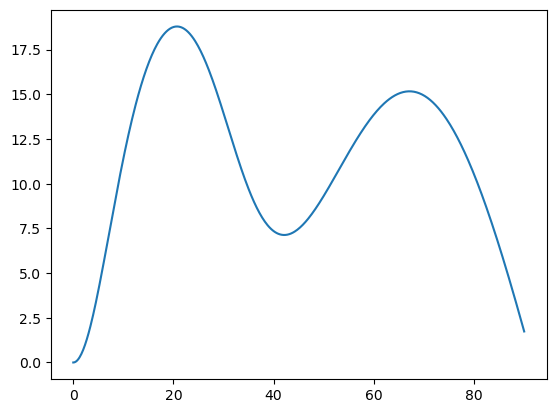

In [3]:
selected_params = get_slider_values(sliders)

x = np.linspace(0, 90, 500)
plt.plot(x, enzyme_truth(x, **selected_params))

### Define appropriate noise

In [ ]:
def plot_noisy_samples(sigma_0, sigma_1, max_noise):
    x = np.linspace(0, 90, 500)
    y_noisy = generate_noisy_observations(
        x=x,
        truth_fn=enzyme_truth,
        noise_fn=heteroskedastic_noise,
        truth_params=selected_params,
        sigma_0=sigma_0,
        sigma_1=sigma_1,
        max_noise=max_noise,
    )
    y_true = enzyme_truth(x, **selected_params)
    # noise = heteroskedastic_noise(x, sigma_0, sigma_1, max_noise)
    # y_noisy = y_true + noise

    plt.figure(figsize=(10, 6))
    plt.plot(x, y_true, label="Enzyme Truth", color="blue", linewidth=2)
    plt.scatter(
        x,
        y_noisy,
        color="orange",
        alpha=0.5,
    )
    plt.xlabel("Enzyme Concentration")
    plt.ylabel("Productivity")
    plt.show()


# Sliders for noise parameters
sigma_0_slider = widgets.FloatSlider(
    value=1.25, min=0.01, max=5, step=0.01, description="Sigma_0"
)
sigma_1_slider = widgets.FloatSlider(
    value=3.6, min=0.01, max=5, step=0.01, description="Sigma_1"
)
max_noise_slider = widgets.FloatSlider(
    value=4.5, min=0.1, max=5.0, step=0.05, description="Max Noise"
)

noise_sliders = {
    "sigma_0": sigma_0_slider,
    "sigma_1": sigma_1_slider,
    "max_noise": max_noise_slider,
}

# Create interactive output
controls = VBox([sigma_0_slider, sigma_1_slider, max_noise_slider])
widget = interactive_output(
    plot_noisy_samples,
    {
        "sigma_0": sigma_0_slider,
        "sigma_1": sigma_1_slider,
        "max_noise": max_noise_slider,
    },
)

# Display the layout and widget
display(VBox([controls, widget]))

noise_params = get_slider_values(noise_sliders)

### With custom ground truth and observation noise - Let's start modeling
Obtain initial datapoints. Utilize sobol sequence to generate initial space filling training data with the generate_noisy_observation function. 
6-8 points should be sufficient.


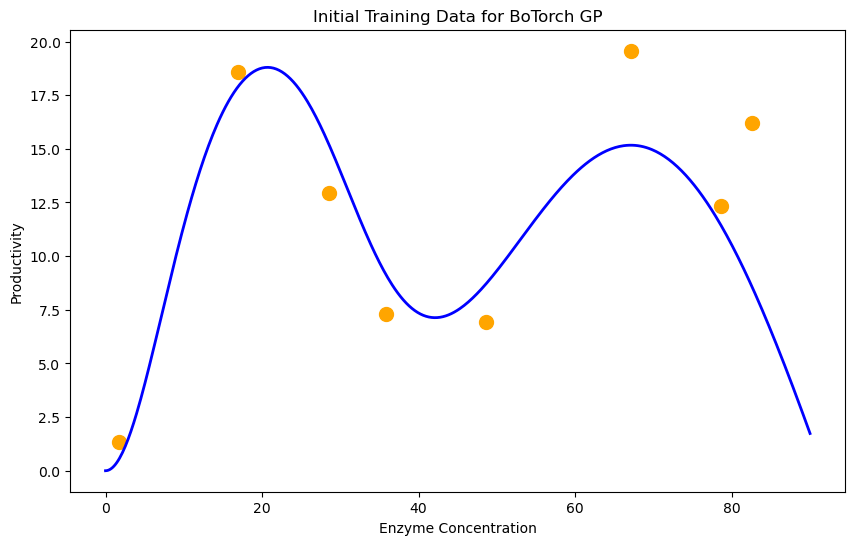

In [5]:
# Generate Sobol points
num_points = 12
x_init = generate_sobol_points(num_points, range_min=0, range_max=90)

# Generate noisy observations using Sobol points
y_init = generate_noisy_observations(
    x=x_init,
    truth_fn=enzyme_truth,
    noise_fn=heteroskedastic_noise,
    truth_params=selected_params,
    noise_params=noise_params,
)

train_x = torch.tensor(x_init, dtype=dtype).unsqueeze(-1)
train_y = torch.tensor(y_init, dtype=dtype).unsqueeze(-1)

# Plot the training data
plt.figure(figsize=(10, 6))
plt.scatter(
    train_x.numpy(), train_y.numpy(), color="orange", label="Noisy Observations", s=100
)
plt.plot(
    np.linspace(0, 90, 500),
    enzyme_truth(np.linspace(0, 90, 500), **selected_params),
    color="blue",
    label="Ground Truth",
    linewidth=2,
)
plt.title("Initial Training Data for BoTorch GP")
plt.xlabel("Enzyme Concentration")
plt.ylabel("Productivity")
plt.show()

Make reasonable prepearations for the small dataset (normalize)
Fit a Botorch GP with RBF Kernel, length scale prior half the distance von xmax-xmin

# Implement here

In [ ]:
class CustomSingleTaskGP(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        # Transform outputs to standardize
        outcome_transform = Standardize(m=1)

        # Initialize the GP
        super().__init__(train_X, train_Y, outcome_transform=outcome_transform)

        # Define the kernel with the prior
        self.covar_module = ScaleKernel(
            RBFKernel(
                lengthscale_prior=LogNormalPrior(
                    loc=np.log((x.max() - x.min()) / 3), scale=0.2
                )  # LogNormal prior for length scale
            )
        )


# Fit the model
def fit_gp_model(train_x, train_y):
    """
    Fit a Gaussian Process model to the training data.

    Parameters
    ----------
    train_x : torch.Tensor
        The training inputs.
    train_y : torch.Tensor
        The training targets.

    Returns
    -------
    model : CustomSingleTaskGP
        The fitted Gaussian Process model.
    """
    model = CustomSingleTaskGP(train_x, train_y)

    # Define the Marginal Log Likelihood (MLL)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    return model


gp_model = fit_gp_model(train_x, train_y)

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


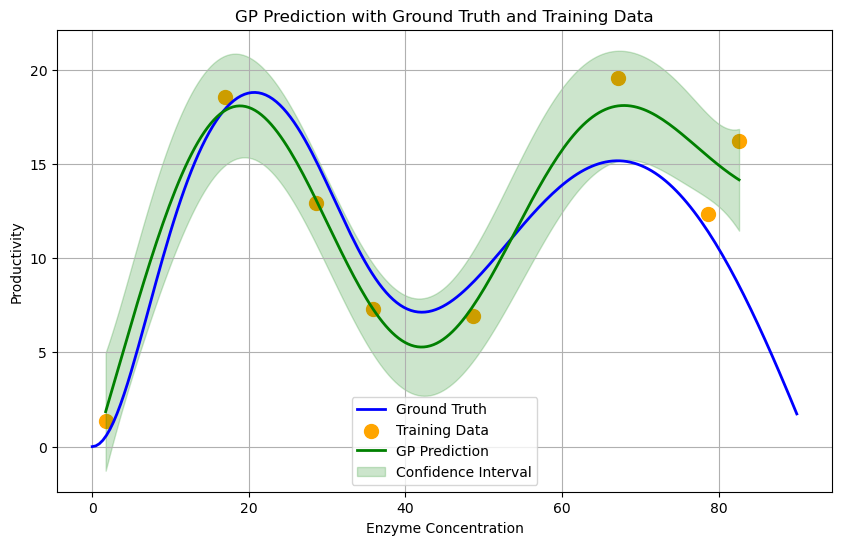

In [ ]:
x_test = torch.linspace(train_x.min(), train_x.max(), 200).unsqueeze(-1)

gp_model.eval()
with torch.no_grad():
    posterior = gp_model.posterior(x_test)
    mean = posterior.mean
    lower, upper = posterior.mvn.confidence_region()

mean = mean.numpy()
lower = lower.numpy()
upper = upper.numpy()

plt.figure(figsize=(10, 6))

# Plot ground truth
x_ground_truth = np.linspace(0, 90, 200)
y_ground_truth = enzyme_truth(x_ground_truth, **selected_params)
plt.plot(
    x_ground_truth, y_ground_truth, label="Ground Truth", color="blue", linewidth=2
)

# Plot training data
plt.scatter(
    train_x.numpy(), train_y.numpy(), color="orange", label="Training Data", s=100
)

# Plot GP prediction
plt.plot(x_test.numpy(), mean, label="GP Prediction", color="green", linewidth=2)

# Plot confidence intervals
plt.fill_between(
    x_test.squeeze(-1).numpy(),
    lower,
    upper,
    alpha=0.2,
    color="green",
    label="Confidence Interval",
)

plt.title("GP Prediction with Ground Truth and Training Data")
plt.xlabel("Enzyme Concentration")
plt.ylabel("Productivity")
plt.legend()
plt.grid(True)
plt.show()